11785 - Midterm Submission

The following code is for training a self supervised model that predicts depth from images, where training is done using stereo pairs from the KITTI dataset

In [1]:
import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json


## Some helper functions are used from the original implementation
from utils import *
from kitti_utils import *
from layers import *


import datasets
from depthDecoder import *
# import networks
from IPython import embed


cuda = torch.cuda.is_available()
cuda

True

In [2]:
class Conv3x3(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(Conv3x3, self).__init__()

        self.pad = nn.ReflectionPad2d(1)

        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out


class ConvBlock(nn.Module):


    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out

class Decoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(Decoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)
        
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [F.interpolate(x, scale_factor=2, mode="nearest")]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs


In [3]:
class ResBlock(nn.Module):
    def __init__(self, input_channel, channel, kernel_size, stride_val):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channel, channel, kernel_size, stride_val,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, kernel_size, stride=1, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(channel)
        
        self.conv3_sc = torch.nn.Conv2d(input_channel,channel,kernel_size=1,stride=stride_val,bias = False)
        self.bn3_sc = torch.nn.BatchNorm2d(channel)
        
        self.conv3 = nn.Conv2d(channel, channel, kernel_size, stride=1,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(channel)
        self.conv4 = nn.Conv2d(channel, channel, kernel_size, stride=1,padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(channel)
    
    def forward(self, x):
        
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.bn3_sc(self.conv3_sc(identity))
        out += identity
        out = F.relu(out)
        
        identity1 = out
        out1 = F.relu(self.bn3(self.conv3(out)))
        out1 = self.bn4(self.conv3(out1))
        out1 += identity1
        out1 = F.relu(out1)
        return out     

class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()
        
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResBlock(input_channel = 64, channel = 64, kernel_size = 3, stride_val = 1)
        self.layer2 = ResBlock(input_channel = 64, channel = 128, kernel_size = 3, stride_val = 2)
        self.layer3 = ResBlock(input_channel = 128, channel = 256, kernel_size = 3, stride_val = 2)
        self.layer4 = ResBlock(input_channel = 256, channel = 512, kernel_size = 3, stride_val = 2)

    
    
    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.conv1(x)
        x = self.bn1(x)
        self.features.append(self.relu(x))
        self.features.append(self.layer1(self.maxpool(self.features[-1])))
        self.features.append(self.layer2(self.features[-1]))
        self.features.append(self.layer3(self.features[-1]))
        self.features.append(self.layer4(self.features[-1]))

        return self.features

In [4]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [5]:
class MainDataset(data.Dataset):
    
    def __init__(self,data_path,filenames,height,width,frame_idxs,num_scales,is_train=False,img_ext='.jpg'):
        super(MainDataset, self).__init__()
        
        self.data_path = data_path
        self.filenames = filenames
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.frame_idxs = frame_idxs
        self.is_train = is_train
        self.img_ext = img_ext
        
        self.interp = Image.ANTIALIAS
        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()
        
        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.ColorJitter.get_params(
                self.brightness, self.contrast, self.saturation, self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

               
        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),interpolation=self.interp)
            
        self.load_depth = self.check_depth()
        
        self.K = np.array([[0.58, 0, 0.5, 0],
                           [0, 1.92, 0.5, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)

        self.full_res_shape = (1242, 375)
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}
        
        
    def __len__(self):
        return len(self.filenames)
    
    def preprocess(self, inputs, color_aug):
        
        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))
                
    

                    
    def check_depth(self):
        line = self.filenames[0].split()
        scene_name = line[0]
        frame_index = int(line[1])

        velo_filename = os.path.join(
            self.data_path,
            scene_name,
            "velodyne_points/data/{:010d}.bin".format(int(frame_index)))

        return os.path.isfile(velo_filename)
    
    def get_color(self, folder, frame_index, side, do_flip):
    #def get_color(self, folder, frame_index, side):
        
        color = self.loader(self.get_image_path(folder, frame_index, side))
        
        if do_flip:
            color = color.transpose(pil.FLIP_LEFT_RIGHT)

        return color
    
    def get_image_path(self, folder, frame_index, side):
        f_str = "{:010d}{}".format(frame_index, self.img_ext)
        image_path = os.path.join(
            self.data_path, folder, "image_0{}/data".format(self.side_map[side]), f_str)
        return image_path

    def get_depth(self, folder, frame_index, side):
        calib_path = os.path.join(self.data_path, folder.split("/")[0])

        velo_filename = os.path.join(
            self.data_path,
            folder,
            "velodyne_points/data/{:010d}.bin".format(int(frame_index)))

        depth_gt = generate_depth_map(calib_path, velo_filename, self.side_map[side])
        depth_gt = skimage.transform.resize(
            depth_gt, self.full_res_shape[::-1], order=0, preserve_range=True, mode='constant')


        return depth_gt
    

                    
    def __getitem__(self, index):
        
        inputs = {}
        
        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5
        
        line = self.filenames[index].split()
        folder = line[0]
        
        
        
        if len(line) == 3:
            frame_index = int(line[1])
            side = line[2]
        else:
            frame_index = 0
            side = None

        for i in self.frame_idxs:
            if i == "s":
                other_side = {"r": "l", "l": "r"}[side]
                inputs[("color", i, -1)] = self.get_color(folder, frame_index, other_side, do_flip)
                #inputs[("color", i, -1)] = self.get_color(folder, frame_index, other_side)
            else:
                inputs[("color", i, -1)] = self.get_color(folder, frame_index + i, side, do_flip)
                #inputs[("color", i, -1)] = self.get_color(folder, frame_index + i, side)
                
        for scale in range(self.num_scales):
            K = self.K.copy()

            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)

            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        if do_color_aug:
            color_aug = transforms.ColorJitter.get_params(
                self.brightness, self.contrast, self.saturation, self.hue)
        else:
            color_aug =  (lambda x: x)
            
        self.preprocess(inputs,color_aug)
        
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]
            
        if self.load_depth:
            depth_gt = self.get_depth(folder, frame_index, side)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))
            
        if "s" in self.frame_idxs:
            stereo_T = np.eye(4, dtype=np.float32)
            baseline_sign =  +1 #-1 if do_flip else 1
            side_sign = -1 if side == "l" else 1
            stereo_T[0, 3] = side_sign * baseline_sign * 0.1

            inputs["stereo_T"] = torch.from_numpy(stereo_T)

        return inputs

In [6]:
## Load the data according to files listed in eigen_full split 

dataset = datasets.KITTIRAWDataset
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_full/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_full/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [7]:
## Size to rescale all input images to
height = 192
width = 640

## Scales of the output image from each layer of the decoder
## output scale = input scale/2**(n) for n in scales
scales = np.arange(4)

img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")

## List of frames that the dataloader must return 
## 0 - present frame
## 's' - stereo couple frame
frame_ids = [0,'s']



weights_pretrained = True

num_scales = len(scales)
num_input_frames = len(frame_ids)

learning_rate = 0.0001

In [8]:
batch_size = 4
num_workers = 8

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [20]:
class DepthEncoderModule(nn.Module):
    def __init__(self, layers):
        super(DepthEncoderModule, self).__init__()
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        pretrained = True
        self.encoder = models.resnet18(pretrained)

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

In [21]:
params = []

## Initialize the models

# encoder = ResnetEncoder()
encoder = DepthEncoderModule(layers = 34)
params += list(encoder.parameters())


decoder = Decoder(encoder.num_ch_enc, scales)
# decoder = Decoder(encoder.num_ch_enc, scales)
params += list(decoder.parameters())


ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
optimizer = optim.Adam(params, learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


In [22]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
#print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

In [23]:

def generate_images_pred(inputs, outputs):
        
   
    source_scale = 0
    
    for scale in scales:
        disp = outputs[("disp", scale)]

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        outputs[("depth", 0, scale)] = depth

        T = inputs["stereo_T"]

        cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
        pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)
        outputs[("color", 's', scale)] = F.grid_sample(inputs[("color", 's', source_scale)],
                pix_coords,
                padding_mode="border",align_corners=False)

    return outputs   


In [24]:

def compute_reprojection_loss(pred, target):

        l1_loss = (torch.abs(target - pred)).mean(1,True)
        
        ssim_loss = ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85*ssim_loss + 0.15 * l1_loss

        return reprojection_loss


In [25]:
def get_smooth_loss(disp, img):

    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


In [26]:

def compute_losses(inputs, outputs):

        losses = {}
        total_loss = 0
        

        for scale in scales:
            loss = 0
            reprojection_losses = []

            source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]


            pred = outputs[("color", 's', scale)]
            reprojection_losses.append(compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            to_optimise, idxs = torch.min(reprojection_losses, dim=1)
            #to_optimise = reprojection_losses
            loss = loss + to_optimise.mean()

            norm_disp = disp / (disp.mean(2, True).mean(3, True)+ 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss =  loss + ((1e-3)*smooth_loss) / (2 ** scale)
            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

        total_loss = total_loss/num_scales
        losses["loss"] = total_loss
        return losses



In [27]:

def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [28]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        encoder.train()
        decoder.train()
        
        for epoch in range(num_epochs):
            lr_scheduler.step()
            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):

                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputsl = decoder(features)

       
                outputs = generate_images_pred(inputs, outputsl)
                

                losses = compute_losses(inputs, outputs)
                total_loss = total_loss + losses['loss'].item()
                
                losses["loss"].backward()
                optimizer.step()
                #lr_scheduler.step()

                del inputs, outputs, features
                if batch_idx%1000==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    #print('Loss: ',total_loss/(batch_idx+1))
                    print('Loss: ',losses["loss"].cpu().data)
                del losses
                    
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(encoder,decoder,val_loader)

In [29]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [17]:

num_epochs = 1
train(encoder,decoder,train_loader,val_loader,num_epochs)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Training Epoch:   9%|▉         | 1003/11300 [04:06<28:13,  6.08it/s] 

Batch No:  1000
Loss:  tensor(0.1866)


Training Epoch:  18%|█▊        | 2001/11300 [08:06<31:29,  4.92it/s]  

Batch No:  2000
Loss:  tensor(0.2095)


Training Epoch:  27%|██▋       | 3003/11300 [12:09<36:34,  3.78it/s]  

Batch No:  3000
Loss:  tensor(0.1795)


Training Epoch:  35%|███▌      | 4003/11300 [16:12<24:51,  4.89it/s]  

Batch No:  4000
Loss:  tensor(0.1544)


Training Epoch:  44%|████▍     | 5002/11300 [20:16<19:54,  5.27it/s]  

Batch No:  5000
Loss:  tensor(0.1655)


Training Epoch:  53%|█████▎    | 6003/11300 [24:19<18:52,  4.68it/s]

Batch No:  6000
Loss:  tensor(0.2106)


Training Epoch:  62%|██████▏   | 7001/11300 [28:20<13:13,  5.42it/s]

Batch No:  7000
Loss:  tensor(0.1464)


Training Epoch:  71%|███████   | 8001/11300 [32:23<10:14,  5.37it/s]

Batch No:  8000
Loss:  tensor(0.1148)


Training Epoch:  80%|███████▉  | 9001/11300 [36:27<06:04,  6.30it/s]

Batch No:  9000
Loss:  tensor(0.1636)


Training Epoch:  89%|████████▊ | 10003/11300 [40:30<04:04,  5.31it/s]

Batch No:  10000
Loss:  tensor(0.1350)


Training Epoch:  97%|█████████▋| 11003/11300 [44:35<01:00,  4.88it/s]

Batch No:  11000
Loss:  tensor(0.1543)


Training Epoch: 100%|██████████| 11300/11300 [45:45<00:00,  7.61it/s]

Train Loss at Epoch_1: 0.15390972698948024
Total Loss (Validation):  0.14415924665560056
Error Metrics:  [0.11936152 1.00084327 5.05018862 0.20551661 0.86987821 0.95316262
 0.97948699]


In [30]:
encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
params_enc = sum([np.prod(p.size()) for p in encoder_parameters])
decoder_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
params_dec = sum([np.prod(p.size()) for p in decoder_parameters])
print(params_enc+params_dec)

14842236


In [ ]:
i = 0
total_loss = 0
train_loader = val_loader
for batch_idx, inputs in enumerate(train_loader):
                optimizer.zero_grad()

                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
               
                o1 = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, o1)
                
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                i = i+1
                
                lr_scheduler.step()
                
                if i>2:
                    break
                   
                del inputs, outputs, losses,features,o1
                

In [ ]:
outputs[('disp', 3)]

In [26]:
image_path = "/home/ubuntu/monodepth2/depthimages/depthimages/678Piazza.JPG"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [27]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    features = encoder(input_image_pytorch.to(device))
    outputs = decoder(features)

disp = outputs[("disp", 0)]

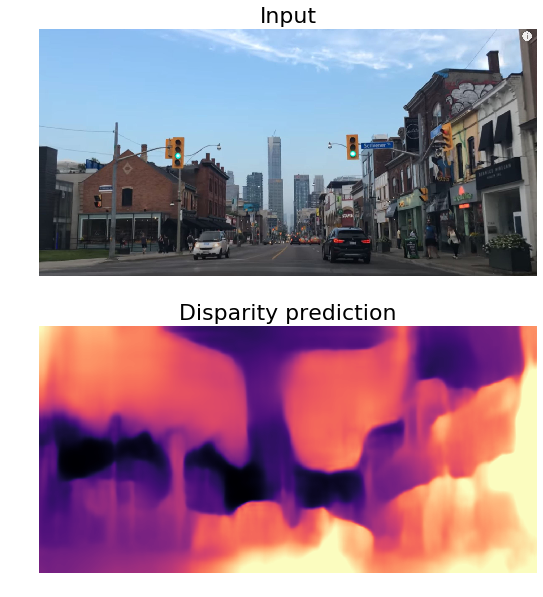

In [31]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');
# plt.save()

In [ ]:
a = val_dataset[0][('color_aug', 's', 0)]
b = val_dataset[0][('color', 0, 0)]

In [ ]:
class ss(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(ss, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


In [ ]:
s = ss()

In [ ]:
validation(encoder,decoder,val_loader)

In [ ]:
import os

test_path = "/home/ubuntu/monodepth2/kitti_data"

ftest = "/home/ubuntu/monodepth2/splits/eigen/test_files.txt"
test_filenames = open(ftest).readlines()


for f in test_filenames:
    path = f.split(" ")
    
    
    if path[2]=='l\n':
        image_path = os.path.join(test_path,path[0],"image_03/data",path[1])
    else:
        image_path = os.path.join(test_path,path[0],"image_04/data",path[1])
    print(image_path)
    input_image = pil.open(image_path+".jpg").convert('RGB')
    original_width, original_height = input_image.size
    input_image_resized = input_image.resize((width, height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        features = encoder(input_image_pytorch.to(device))
        outputs = decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off');
    
    plt.savefig('output_imgs_10epochs/'+path[1]+'.png',dpi = 100)
    
    plt.close('all')
    del outputs,features



In [ ]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [ ]:
torch.save(encoder,'encoder10e.pt')
torch.save(decoder,'decoder10e.pt')

In [29]:
encoder = torch.load('encoder10e.pt')
decoder = torch.load('decoder10e.pt')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'networks.resnet_encoder.ResnetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [30]:
print(encoder)

ResnetEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra